<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

# CAMS Dust monitoring


In this tutorial we will access and view data from both the Copernicus Climate Change Service (C3S) and the Copernicus Atmosphere Monitoring Service (CAMS). The tutorial includes the following parts:

3. [CAMS European air quality forecast data](#EurAQ): Download CAMS European air quality forecast data (dust and PM10) from ADS. View both dust and PM10 data in separate plots.

4. [CAMS near-real-time global AOD](#AOD): Download total Aerosol Optical Depth (AOD) data from 5 days ago using the CAMS catalogue. View the data in a plot.

### About

This notebook provides you a practical introduction to the topic of how to compute climatologies and anomalies on different spatial and temporal levels.

The notebooks has four sections. The first section [1 - Data preparation](#data_preparation) is mandatory, as it loads and prepares the dataset for the following parts. Sections 2 to 4 are practical examples of how to compute and analyse climatologies and anomalies on different spatial (global and regional) and temporal (annual, monthly and seasonal) levels.

The notebook has the following outline:

* [1 - Data preparation](#data_preparation)
* [2 - Calculation of the annual global mean surface air temperature anomaly](#global_mean)
* [3 - Calculation of the monthly surface air temperature anomaly in Europe](#monthly_europe)
* [4 - Calculation of seasonal variations of near-surface air temperature over the Arctic](#seasonal_arctic)

### Data

This notebook introduces you to the ERA5 reanalysis monthly averaged data on single levels. The data has the following specifications:

> **Data**: `ERA5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Jan 1979 to Dec 2020` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

Get [here](./101_c3s_data_intro.ipynb) more information about climate reanalysis data in general including an overview of they different dataset types.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

### Further resources

* [New decade brings reference period change for climate data](https://climate.copernicus.eu/new-decade-reference-period-change-climate-data)
* [2020 closes a decade of exceptional heat](https://public.wmo.int/en/media/news/2020-closes-decade-of-exceptional-heat)
* [Copernicus: 2020 warmest year on record for Europe; globally, 2020 ties with 2016 for warmest year recorded](https://climate.copernicus.eu/2020-warmest-year-record-europe-globally-2020-ties-2016-warmest-year-recorded)

<hr>

### Load libraries

In [4]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='EurAQ'></a>CAMS European air quality forecast data

In this part of the tutorial we will download CAMS European air quality forecast data from the ADS https://ads.atmosphere.copernicus.eu. The ADS is very similar to the CDS and has the same keyword and filters functionality to refine your search. We will search for the following dataset: `CAMS European air quality forecasts`.

Having selected the correct dataset, we now need to specify what variable, parameters and temporal coverage we are interested in. These can all be specified in the **"Download data"** tab. In this tab, just as with the CDS, a form appears in which we will select the following parameters to download:

- Variable: `Dust` and `Particulate matter < 10 µm (PM10)`
- Model: `Ensemble median`
- Level: `0` (height in meters)
- Date: Start: `2021-02-20`, End: `2021-02-20`
- Type: `Analysis` (default)
- Time: `12:00` 
- Leadtime hour: `0` (default for analysis)
- Area: `Full model area`
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)...

### Download data from ADS

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your specified directory.

In [56]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)
c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': [
            'dust', 'particulate_matter_10um',
        ],
        'model': 'ensemble',
        'level': '0',
        'date': '2021-02-20/2021-02-20',
        'type': 'analysis',
        'time': '12:00',
        'leadtime_hour': '0',
        'format': 'netcdf',
    },
    f'{DATADIR}/CAMS_AirQuality_20210220.nc')

C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-02-21 16:27:00,718 INFO Welcome to the CDS
2021-02-21 16:27:00,722 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-02-21 16:27:00,805 INFO Request is queued
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS reque

Result(content_length=2357960,content_type=application/x-netcdf,location=https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data8/adaptor.cams_regional_fc.retrieve-1613924820.3752525-31115-16-0b8f3a25-3cb1-4f87-89f0-7e3d773cb33c.nc)

### Read CAMS air quality data and inspect metadata

We will now read and inspect this data:

In [17]:
# Create filename variable
fn = f'{DATADIR}/CAMS_AirQuality_20210220.nc'
# Read the air quality data into an xarray data-set
ds_aq = xr.open_dataset(fn)

In [18]:
# Inspect the data (note the two variables of dust and PM10)
ds_aq

<xarray.Dataset>
Dimensions:    (latitude: 420, level: 1, longitude: 700, time: 1)
Coordinates:
  * longitude  (longitude) float32 335.05 335.15 335.25 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 12:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
    pm10_conc  (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust/PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210220+[12H_12H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust/PM10 concentration a...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

### Plot map of dust over Europe

Let's look more closely at the dust data:

In [19]:
# Create a data array of just the dust data:
dust = ds_aq['dust']
# as there is only one level and one time, we can remove
# these by dropping all coordinates with only one entry
dust = dust.squeeze(drop=True)

We can visualise this data by plotting it onto a map of Europe. 

For this plot, we may want to create a customised colourmap similar to that used in CAMS products. This is optional however, as there are many default colourmaps that can be used, which are listed here: https://matplotlib.org/stable/gallery/color/colormap_reference.html.

In [20]:
# The colour map typically used in CAMS is a discrete, not continuous, colour scale. Each
# row in 'matrix' corresponds to one of the 14 colours in the scale, and each of the three
# columns corresponds to red, green and blue, respectively. The numbers range from 0 (black)
# to 256 (white).
matrix = np.array([[210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])

# Each of the 14 colours in the colourmap will be multiplied by n to create a final
# colourmap of 14*18+1=253 listed colours. The addition of 1 is just to create a starting
# colour of white.
n = 18

# 'cams' is an initial empty colourmap, to be filled by the colours provided in 'matrix'.
cams = np.ones((253, 4))

# This loop fills in the empty 'cams' colourmap with each of the 14 colours in 'matrix'
# multiplied by 'n', with the first row left as 1 (white). Note that each colour value is 
# divided by 256 to normalise the colour range from 0 (black) to 1 (white). 
for i in range(matrix.shape[0]):
    cams[((i*n)+1):(((i+1)*n)+1),:] = np.array([matrix[i,0]/256, matrix[i,1]/256, matrix[i,2]/256, 1])

# The final colourmap is given by 'camscmp', which uses the Matplotlib class 'ListedColormap(Colormap)'
# to generate a colourmap object from the list of colours provided by 'cams'.
camscmp = ListedColormap(cams)

Now we can plot the data with the customised colourmap we have created.

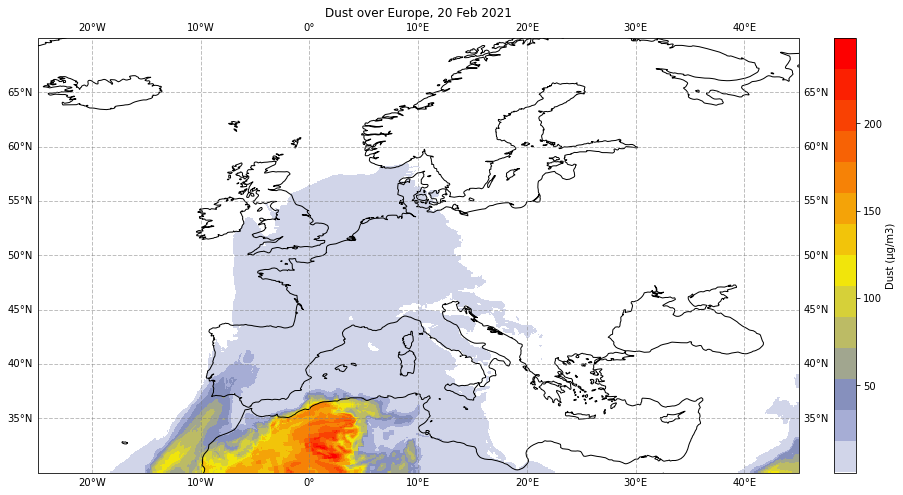

In [21]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.set_extent([-25,45,30,70], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Dust over Europe, 20 Feb 2021', fontsize=12)
im = plt.pcolormesh(dust['longitude'].values, dust['latitude'].values,
                    dust, cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Dust (µg/m3)')
fig.savefig(f'{DATADIR}/Dust_Europe_20210220.png')

### Plot map of PM10 over Europe

Let us now compare this with a map of the other variable: PM10

In [22]:
pm10 = ds_aq['pm10_conc']
pm10 = pm10.squeeze(drop=True)

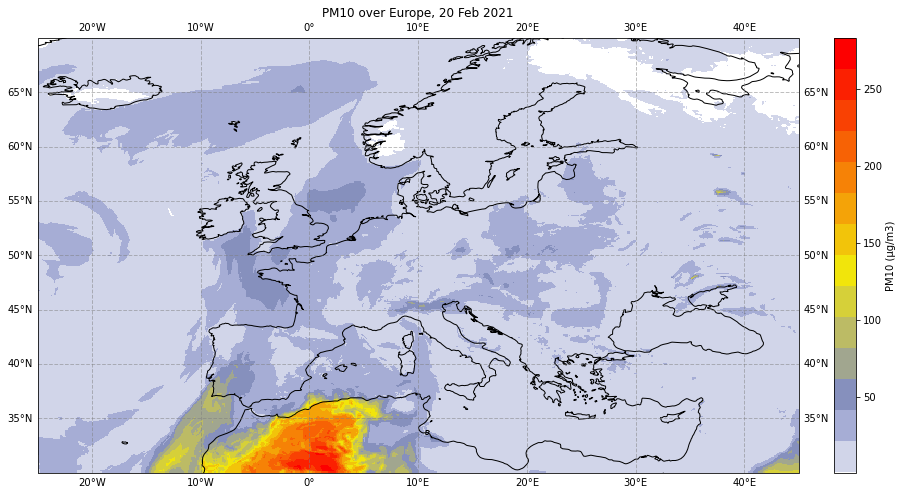

In [23]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.set_extent([-25,45,30,70], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('PM10 over Europe, 20 Feb 2021', fontsize=12)
im = plt.pcolormesh(pm10['longitude'].values, pm10['latitude'].values,
                    pm10, cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('PM10 (µg/m3)')
fig.savefig(f'{DATADIR}/PM10_Europe_20210220.png')

## <a id='AOD'></a>CAMS near-real-time global AOD

In this final part of the tutorial we will retrieve near real-time (older than five days) data for total Aerosol Optical Depth (AOD) at 550 nm, from the CAMS catalogue https://atmosphere.copernicus.eu/catalogue#/. This catalogue contains a large number of freely accessible datasets, categorised into product and parameter groups. 

The dataset we will use is accessible through the catalogue, but can ultimately be downloaded from the CAMS Near-real-time download form https://apps.ecmwf.int/datasets/data/cams-nrealtime/levtype=sfc/.

We will use this web form to download the following dataset:

- Month: `Feb 2021`
- Time: `00:00`
- Step: `0` (lead time)
- Parameter: `Total Aerosol Optical Depth at 550nm`

Having selected the fields above, click `Retrieve NetCDF`. This will lead you to a summary page where you can submit your request. As soon as this has been processed, a link will be provided to download the data.

Having downloaded the data, place it in your `data` directory. After which we will open it and create a plot.

### Read NRT data on total AOD at 550nm

In [24]:
fn = f'{DATADIR}/CAMS_NRT_AOD.nc'
ds_aod = xr.open_dataset(fn)

In [25]:
ds_aod

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 900, time: 14)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-02-01T18:00:00 ... 2021-02-14T18:00:00
Data variables:
    aod550     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-19 22:47:05 GMT by grib_to_netcdf-2.19.1: grib_to_n...

Notice how there are 14 time steps in the dataset corresponding to the days in February up to 5 days ago.

In [26]:
# Create xarray dataset
aod = ds_aod['aod550']

### Create global map of total AOD at 550nm
Here we create a 2d map of total AOD at 550nm for the first time step, 1 February 2021.

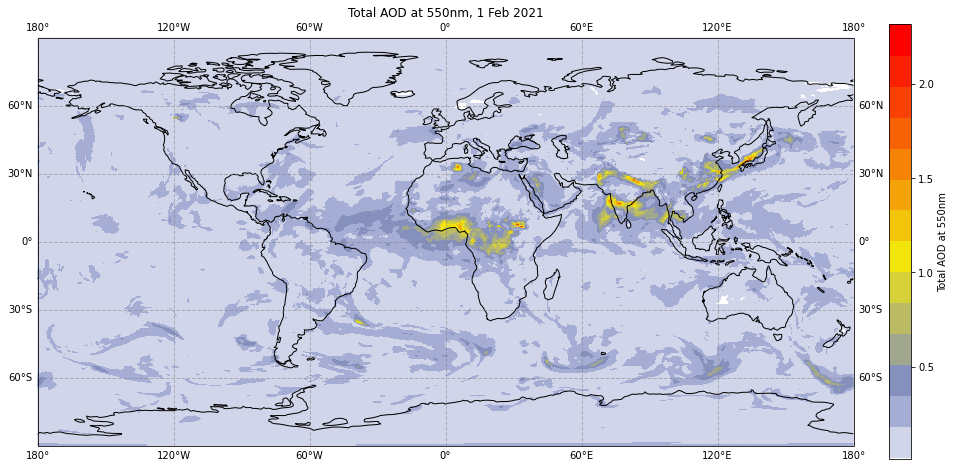

In [33]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_title('Total AOD at 550nm, 1 Feb 2021', fontsize=12)
im = plt.pcolormesh(aod.longitude, aod.latitude, aod[0,:,:],
                    cmap=camscmp, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Total AOD at 550nm')
fig.savefig(f'{DATADIR}/AOD_20210201.png')

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>